In [4]:

from __future__ import division
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from pybasicbayes.distributions import Regression
from pybasicbayes.util.text import progprint_xrange
from autoregressive.distributions import AutoRegression
import os

absolute_code_path = '/home/marcel/Desktop/Projects/Stitching/code/pyLDS_dev/'
os.chdir(absolute_code_path +'pylds')

from pylds.models import LDS, DefaultLDS
from pylds.distributions import Regression_diag, AutoRegression_input
from pylds.obs_scheme import ObservationScheme
from pylds.user_util import gen_pars, rand_rotation_matrix, init_LDS_model, collect_LDS_stats

from scipy.io import savemat # store results for comparison with Matlab code  

def update(model):
    model.EM_step()
    return model.log_likelihood() 

# Generate data for illustration #1

In [ ]:

np.random.seed(1 * 42 + 1)                   

#########################
#  set some parameters  #
#########################

n = 3
p = 9
T = 10000

num_sets = 10;

# tentative observation scheme:
obs_scheme = {'sub_pops': (np.arange(0, p//2 + 1), np.arange(p//2, p)),
              'obs_pops': np.array((0,1)),
              'obs_time': np.array((T//2,T))
             }

for idx_d in range(num_sets):
    
    print('generating set #', idx_d)
    pars_true, _ = gen_pars(n, p, u_dim=0, 
                 pars_in=None, 
                 obs_scheme=None,
                 gen_A='full', lts=np.linspace(0.95, 0.98, n),
                 gen_B='random', 
                 gen_Q='identity', 
                 gen_mu0='random', 
                 gen_V0='stable', 
                 gen_C='random', 
                 gen_d='scaled', 
                 gen_R='fraction',
                 diag_R_flag=True,
                 x=None, y=None, u=None)

    ###################
    #  generate data  #
    ###################

    truemodel = LDS(
        dynamics_distn=AutoRegression(A=pars_true['A'].copy(),sigma=pars_true['Q'].copy()),
        emission_distn=Regression_diag(A=np.hstack((pars_true['C'].copy(), pars_true['d'].copy().reshape(p,1))),
                                       sigma=pars_true['R'].copy(), affine=True),
                    )
    truemodel.mu_init = pars_true['mu0'].copy()
    truemodel.sigma_init = pars_true['V0'].copy()

    data, stateseq = truemodel.generate(T)


    save_file = '../../../results/cosyne_poster/illustration_1/data/LDS_save_idx'+str(idx_d) 
    save_file_m = {'x': truemodel.states_list[0].stateseq, 
                   'y': truemodel.states_list[0].data,
                   'u' : [], 
                   'T' : truemodel.states_list[0].T, 
                   'Trial': len(truemodel.states_list), 
                   'truePars':pars_true,
                   'obsScheme' : obs_scheme}

    savemat(save_file,save_file_m) # does the actual saving
    
    np.savez(save_file, x=truemodel.states_list[0].stateseq,
                        y= truemodel.states_list[0].data,
                        T=truemodel.states_list[0].T, 
                        Trial=len(truemodel.states_list), 
                        truePars=pars_true,
                        sub_pops=obs_scheme['sub_pops'],            
                        obs_time=obs_scheme['obs_time'],            
                        obs_pops=obs_scheme['obs_pops'])  


# Generate data for illustration #2

In [ ]:

np.random.seed(1 * 42 + 2)

if False:

    save_file = '../../../results/cosyne_poster/illustration_2/data/LDS_save_idx'+str(idx_d) 
    from scipy.io import savemat # store results for comparison with Matlab code   
    from scipy.linalg import solve_discrete_lyapunov as dtlyap # solve discrete-time Lyapunov equation
    save_file_m = {'x': truemodel.states_list[0].stateseq, 
                   'y': truemodel.states_list[0].data,
                   'u' : [], 
                   'T' : truemodel.states_list[0].T, 
                   'Trial': len(truemodel.states_list), 
                   'truePars':pars_true,
                   'obsScheme' : obs_scheme}

    savemat(save_file,save_file_m) # does the actual saving
    
    np.savez(save_file, x=truemodel.states_list[0].stateseq,
                        y= truemodel.states_list[0].data,
                        T=truemodel.states_list[0].T, 
                        Trial=len(truemodel.states_list), 
                        truePars=pars_true,
                        sub_pops=obs_scheme['sub_pops'],            
                        obs_time=obs_scheme['obs_time'],            
                        obs_pops=obs_scheme['obs_pops'])      


# Generate data for simulation #1

In [ ]:
            
#########################
#  set some parameters  #
#########################


ns = np.sort(np.hstack([np.arange(1,10)+1,np.arange(1,10)+1]))
num_sets = ns.size;

p = 30
T = 10000

for idx_d in range(num_sets):
    
    n = ns[idx_d]
    
    if np.mod(idx_d,2)==0:
        overlap = ns[idx_d]
    else:
        overlap = 2
        
    # tentative observation scheme:
    obs_scheme = {'sub_pops': (np.arange(0,p//2+np.ceil(overlap/2.).astype(np.int64)), 
                               np.arange(p//2-np.floor(overlap/2.).astype(np.int64),p)),
              'obs_pops': np.array((0,1)),
              'obs_time': np.array((T//2,T))
             }
    
    print('generating set #', idx_d)
    pars_true, _ = gen_pars(n, p, u_dim=0, 
                 pars_in=None, 
                 obs_scheme=None,
                 gen_A='full', lts=np.linspace(0.95, 0.98, n),
                 gen_B='random', 
                 gen_Q='identity', 
                 gen_mu0='random', 
                 gen_V0='stable', 
                 gen_C='random', 
                 gen_d='scaled', 
                 gen_R='fraction',
                 diag_R_flag=True,
                 x=None, y=None, u=None)

    ###################
    #  generate data  #
    ###################

    truemodel = LDS(
        dynamics_distn=AutoRegression(A=pars_true['A'].copy(),sigma=pars_true['Q'].copy()),
        emission_distn=Regression_diag(A=np.hstack((pars_true['C'].copy(), pars_true['d'].copy().reshape(p,1))),
                                       sigma=pars_true['R'].copy(), affine=True),
                    )
    truemodel.mu_init = pars_true['mu0'].copy()
    truemodel.sigma_init = pars_true['V0'].copy()

    data, stateseq = truemodel.generate(T)


    save_file = '../../../results/cosyne_poster/simulation_1/data/LDS_save_n'+str(n)+'_idx'+str(np.mod(idx_d,2)) 
    save_file_m = {'x': truemodel.states_list[0].stateseq, 
                   'y': truemodel.states_list[0].data,
                   'u' : [], 
                   'T' : truemodel.states_list[0].T, 
                   'Trial': len(truemodel.states_list), 
                   'truePars':pars_true,
                   'obsScheme' : obs_scheme}

    savemat(save_file,save_file_m) # does the actual saving
    
    np.savez(save_file, x=truemodel.states_list[0].stateseq,
                        y= truemodel.states_list[0].data,
                        T=truemodel.states_list[0].T, 
                        Trial=len(truemodel.states_list), 
                        truePars=pars_true,
                        sub_pops=obs_scheme['sub_pops'],            
                        obs_time=obs_scheme['obs_time'],            
                        obs_pops=obs_scheme['obs_pops'])     
    


# Generate data for simulation #2

('generating set #', 0)
[ 0.08041555  2.41141779  5.39066511  0.51141868  1.76749152  0.36100967
  0.67565817  2.507835    2.19437423  0.39861525  0.45512821  5.5919181
  1.54060512  1.17361731  0.29567936  0.10746876  0.19333431  5.15528153
  0.8387103   0.18606898  0.71316522  0.09461609  0.47192663  1.55599805
  2.69837455  0.23568308  0.91195805  0.38911765  5.77888481  0.25213552
  0.45021681  4.31198694  0.90629184  0.11113422  0.35921161  1.85417014
  0.39723608  0.2121694   0.35691693  4.07717271  0.43799398  5.13237147
  0.59260317  0.53066335  0.13288587  0.29399097  0.20426312  1.60485695
  0.35237996  1.79454918]


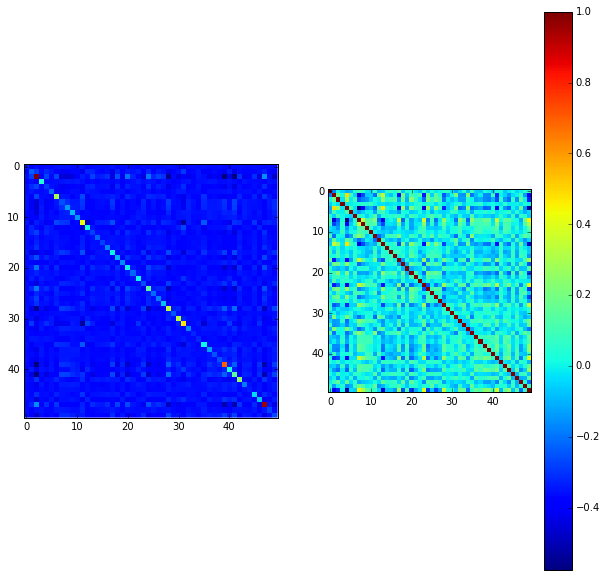

('generating set #', 1)
[ 1.1817524   0.69118016  0.05115285  1.68975635  0.23309574  0.30208495
  0.67280853  6.61077173  1.08490742  0.76261863  0.19484888  1.89118961
  0.57233719  0.91705998  0.1022232   1.08804795  0.27897009  1.83097284
  0.56766334  5.18929532  0.66200123  0.54903129  0.39065475  1.16420759
  3.13872622  2.7206222   0.32555172  2.41954168  4.48688011  0.29655658
  0.7358491   2.63606253  6.29638905  0.42854415  0.79939644  0.37599484
  0.19612706  2.46438002  0.43976268  0.21373472  0.85121878  0.23332082
  0.46100377  0.84947213  0.78656519  2.39893767  0.33131968  0.3549975
  0.62029731  1.56280504]


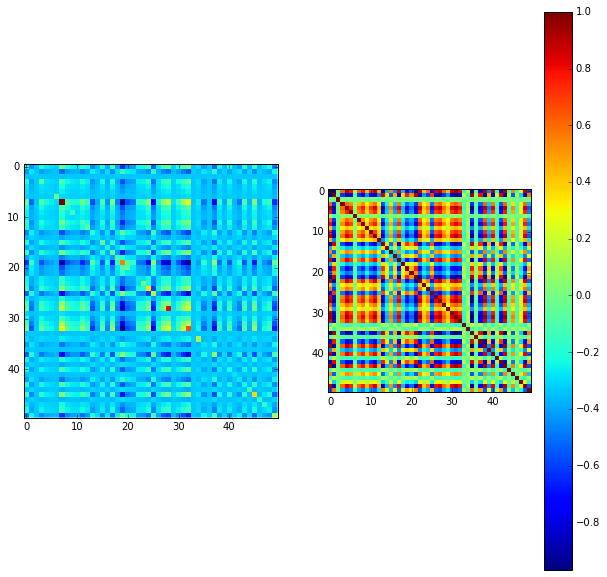

('generating set #', 2)
[ 0.2434892   2.5692362   0.12178734  0.06535063  3.4248303   2.17583101
  0.20317261  0.72776813  1.58902347  0.75142953  1.58210113  0.58510663
  1.53305142  1.06701907  0.73543631  0.40517531  0.28547902  0.62442381
  0.29879228  0.83921505  0.32533759  0.65035838  3.15212478  1.79186414
  0.49167099  0.84455722  0.53854854  1.98087174  0.36803341  2.8670013
  0.44643021  4.87533579  0.09542034  0.77401327  0.50972836  0.37655454
  5.89788838  1.35659834  0.38335973  0.46532242  3.18766815  0.33489886
  0.50073556  0.44517037  1.16031387  0.95138925  5.83404222  0.38931887
  1.44883317  1.19491328]


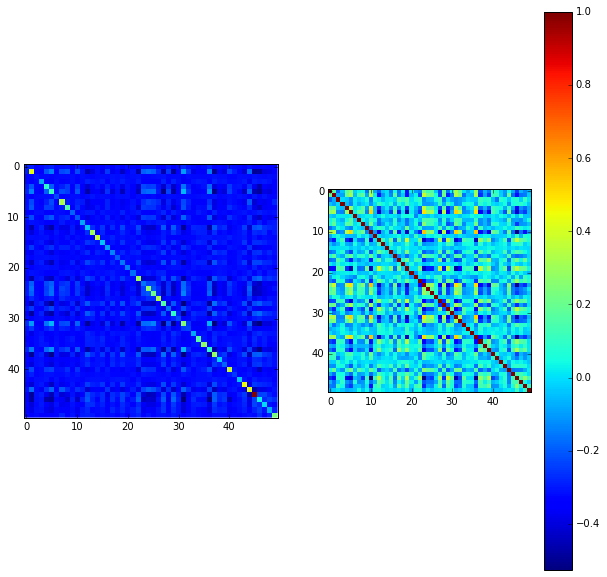

('generating set #', 3)
[  0.63601422   0.42097544  10.70967577   0.14137123   0.21598698
   0.23886794   1.13070607   0.84337777   0.45513682   1.15566397
   2.08569249   1.45253819   1.25743552   0.70075403   2.02393295
   0.65612947   0.14045964   1.55296046   0.33081416   0.65761784
   1.21973861   1.39563078   0.44715619   0.35331771   1.90038664
   0.35594523   1.74455715   0.65944964   1.76495434   0.58479927
   3.57299071   0.75447062   1.21902388   0.38306042   0.62961473
   0.45412005   0.41802345   1.64408909   1.04294176   0.30994404
   1.38354636   1.98213026   0.26227704   2.55071799   0.63649405
   1.79306701   4.68618658   0.7777049    0.48851258   0.34900214]


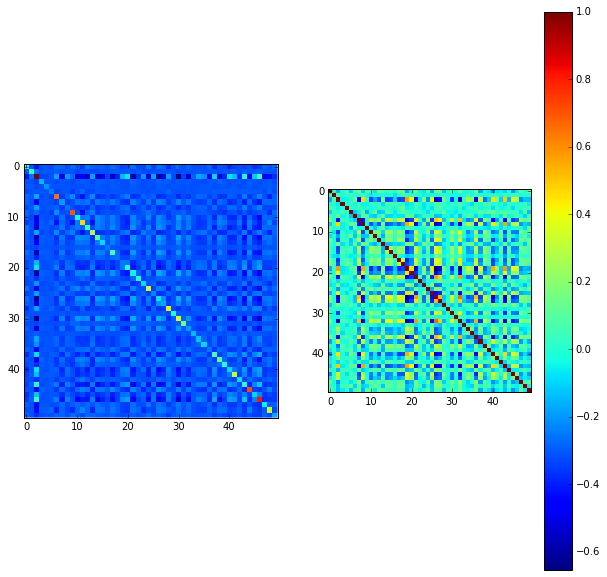

('generating set #', 4)
[ 0.83926185  2.4844601   0.28056951  0.38768115  0.53526919  0.19459178
  6.10117808  0.8256265   1.35390905  0.1746355   0.92213737  0.60224484
  1.06615931  7.30283848  0.24726248  2.79647175  3.7763462   0.17549807
  0.46846439  0.05350613  0.53919014  0.17209406  0.89745481  0.82463789
  1.48944586  1.23641531  1.42073772  1.5543579   3.50893598  0.07151076
  0.08520676  0.52665041  1.38653182  5.60434749  0.56484217  1.38507525
  1.01952406  0.3126516   1.16180406  1.22764178  2.18520643  0.49496695
  0.43246618  0.6045049   0.8724705   1.23278401  0.74230057  0.31631146
  0.2627339   2.38377523]


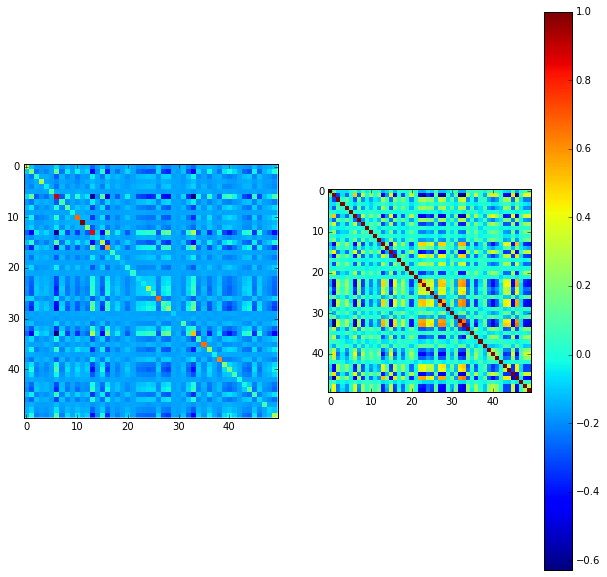

('generating set #', 5)
[ 1.03079664  0.48525595  0.48667826  3.26141767  0.94284639  0.08978848
  2.2660315   7.88912646  0.03627034  0.23648772  0.33174794  0.35562708
  0.81250358  0.40377003  0.97326256  0.74203952  1.07455644  0.93567619
  5.5752553   0.2758721   0.55257333  3.21742703  0.57499891  0.38157551
  4.05821838  0.8514615   0.2567031   0.34828739  3.54832367  0.33635653
  0.75379485  0.29627285  1.04369165  0.86871284  1.73771868  0.62640597
  0.50993969  0.74167215  0.7315778   2.42267965  0.26208633  2.12129927
  0.2568302   1.46266224  0.12718745  1.04830654  0.51406034  6.08126908
  0.83397612  1.08262986]


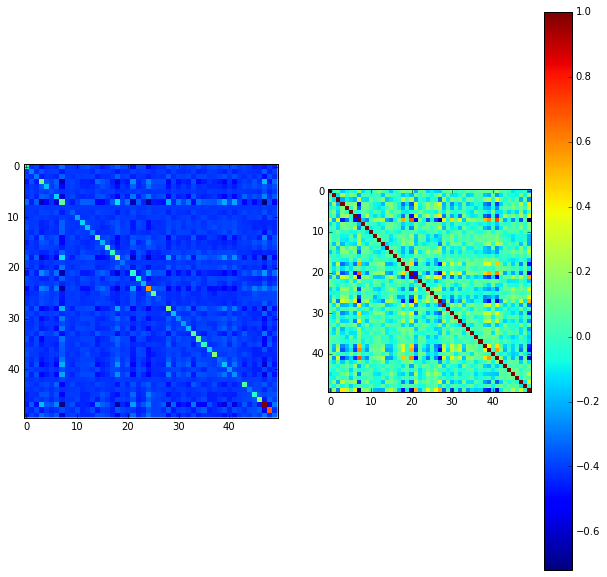

('generating set #', 6)
[ 2.33719088  0.72690871  0.25642317  1.80775257  0.45834347  6.04825204
  0.2901746   0.37856848  0.42566785  0.11197798  0.66152728  1.86348603
  0.59476536  1.03683878  0.17483116  0.9359669   0.95947619  4.64552379
  0.48473802  6.83219991  0.66330482  3.17515449  0.55008349  0.2570004
  1.30206768  0.85703152  0.50326923  0.70624317  3.75133708  1.83542434
  1.27216185  0.38810268  0.64228604  1.64848031  0.24462102  0.41489528
  0.51762306  1.35343861  1.5544578   0.34052145  0.59661256  0.68102597
  0.65095548  0.54688589  0.23241169  0.68984792  0.49333305  5.59209771
  0.90597649  0.6006024 ]


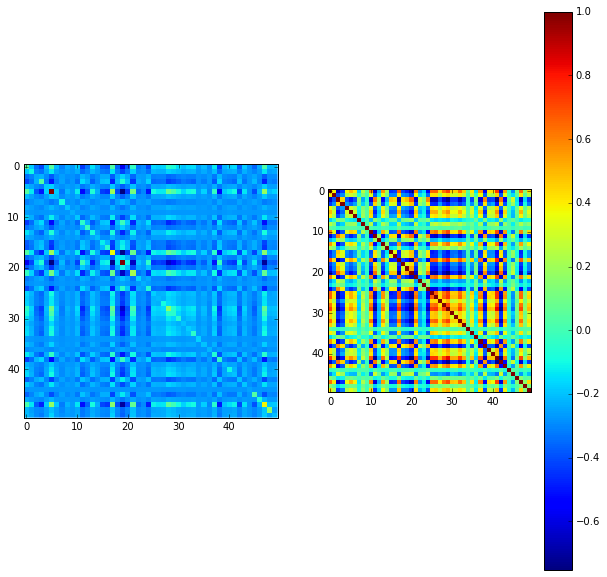

('generating set #', 7)
[ 0.41353031  0.15468253  0.1084281   7.54122824  0.16214543  1.10201838
  2.59109376  8.49158635  0.16081662  4.94850261  0.13830612  0.88252214
  2.90388278  0.5891539   8.67924363  0.39639123  0.39004942  1.23963615
  1.05013571  0.61936015  0.15457723  4.3178211   0.84137394  0.58773003
  1.07978031  0.94186318  0.10609541  0.19542614  0.70671352  0.67964292
  0.13805459  0.16178713  0.1241608   0.41066361  1.30639081  1.33185109
  0.15563594  1.3394972   0.75798948  3.12792893  3.06407262  3.56410715
  0.41052108  0.86239886  0.16429716  0.37537365  1.783401    0.19000098
  0.30769017  0.94844423]


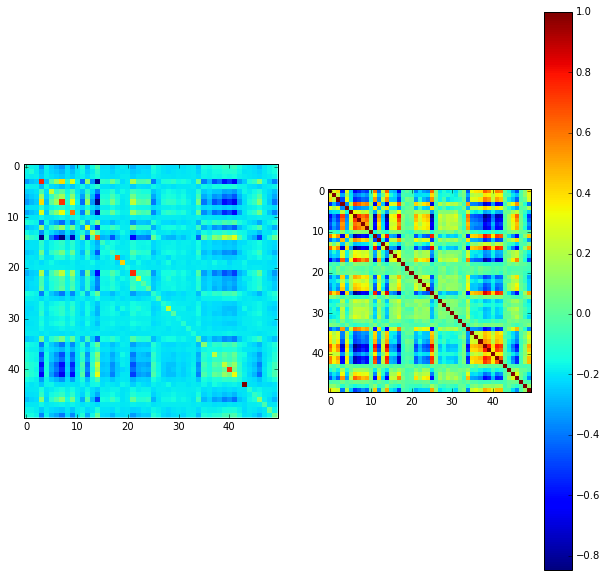

('generating set #', 8)
[ 0.18607451  0.52803386  0.76967362  0.17313301  1.46058071  1.46304979
  2.14442243  0.17408198  0.41641782  0.5135621   0.89280876  0.51128912
  0.30426581  2.91378733  0.44864319  0.20624235  2.50136514  5.17005671
  0.66910048  3.50268046  0.38667246  0.07211982  0.95669082  2.5660284
  0.94503957  3.13266083  0.56640332  3.31580452  0.4750198   0.1680614
  3.83757614  0.59404849  1.57886305  0.24210176  0.77730984  0.48043145
  0.37685383  0.23403548  6.01452091  0.03724274  0.45639226  1.64403128
  2.74505474  1.41939665  1.50562143  1.53976078  1.224153    0.59408716
  0.37695744  0.72801957]


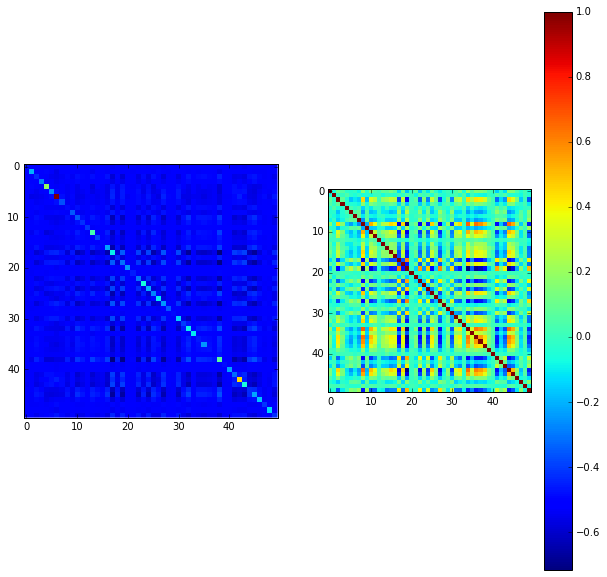

('generating set #', 9)
[ 1.01044422  0.59682749  0.20878676  0.12251406  0.70217139  2.9537514
  0.99536573  0.38070889  0.59925018  0.4092269   1.41632622  1.78031387
  0.61881187  1.07212945  0.47491108  0.26898255  0.61493297  0.47337411
  0.96110053  0.3573508   1.77890909  0.55421505  0.72009487  0.48206232
  1.32320032  2.88426115  3.2890529   0.76545805  1.40428598  0.50442935
  0.08562314  0.8110513   1.16777632  1.48920644  0.51179097  0.61403784
  1.65228795  1.11742276  0.86649399  1.04945531  0.46763787  1.91396703
  0.52992731  0.55593802  4.28584103  4.10787585  0.31466251  1.18228471
  1.30818591  6.00865934]


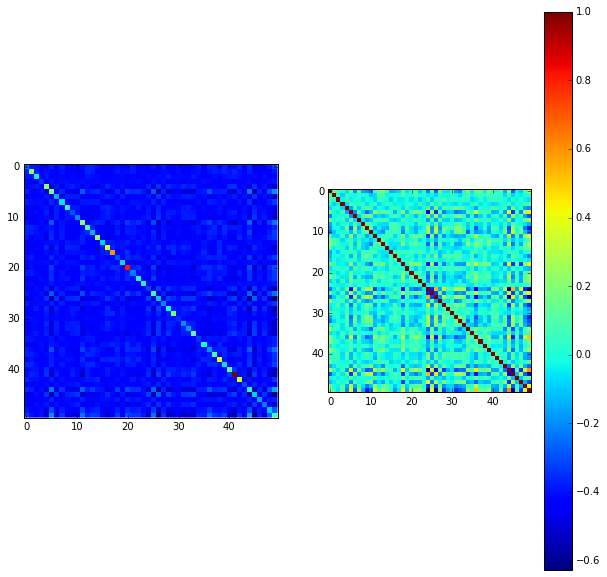

In [5]:
%matplotlib inline
def update(model):
    model.EM_step()
    return model.log_likelihood()                    

#########################
#  set some parameters  #
#########################


num_sets = 10;

n = 5
p = 50
T = 5000

overlap = 2

# tentative observation scheme:
sub_pop1 = np.arange( 0,16)
sub_pop2 = np.arange(14,30)
sub_pop3 = np.hstack([sub_pop1[0],np.arange(sub_pop2[-1], p)])
obs_scheme = {'sub_pops': (sub_pop1, sub_pop2, sub_pop3),
              'obs_pops': np.array((0,1,2)),
              'obs_time': np.array((T//3,T//2,T))
             }

for idx_d in range(num_sets):
    
    
    print('generating set #', idx_d)
    pars_true, _ = gen_pars(n, p, u_dim=0, 
                 pars_in=None, 
                 obs_scheme=None,
                 gen_A='full', lts=np.linspace(0.95, 0.98, n),
                 gen_B='random', 
                 gen_Q='identity', 
                 gen_mu0='random', 
                 gen_V0='stable', 
                 gen_C='random', 
                 gen_d='scaled', 
                 gen_R='fraction',
                 diag_R_flag=True,
                 x=None, y=None, u=None)
    
    means_C =  np.sum(pars_true['C'],axis=1)
    pars_true['C'] -= means_C.reshape(p,1)
    norms_C = np.sum(pars_true['C']*pars_true['C'],axis=1)
    pars_true['C'] /= np.mean(np.sqrt(norms_C.reshape(p,1)))
    #pars_true['R'] = 
    
    print(np.sum(pars_true['C']*pars_true['C'],axis=1))

    ###################
    #  generate data  #
    ###################

    truemodel = LDS(
        dynamics_distn=AutoRegression(A=pars_true['A'].copy(),sigma=pars_true['Q'].copy()),
        emission_distn=Regression_diag(A=np.hstack((pars_true['C'].copy(), pars_true['d'].copy().reshape(p,1))),
                                       sigma=pars_true['R'].copy(), affine=True),
                    )
    truemodel.mu_init = pars_true['mu0'].copy()
    truemodel.sigma_init = pars_true['V0'].copy()

    data, stateseq = truemodel.generate(T)

    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(np.cov(data.T), interpolation='none')
    plt.subplot(1,2,2)
    plt.imshow(np.corrcoef(data.T), interpolation='none')
    plt.colorbar()
    plt.show()
    
    save_file = '../../../results/cosyne_poster/simulation_2/data/LDS_save_idx'+str(idx_d) 
    save_file_m = {'x': truemodel.states_list[0].stateseq, 
                   'y': truemodel.states_list[0].data,
                   'u' : [], 
                   'T' : truemodel.states_list[0].T, 
                   'Trial': len(truemodel.states_list), 
                   'truePars':pars_true,
                   'obsScheme' : obs_scheme}

    savemat(save_file,save_file_m) # does the actual saving
    
    np.savez(save_file, x=truemodel.states_list[0].stateseq,
                        y= truemodel.states_list[0].data,
                        T=truemodel.states_list[0].T, 
                        Trial=len(truemodel.states_list), 
                        truePars=pars_true,
                        sub_pops=obs_scheme['sub_pops'],            
                        obs_time=obs_scheme['obs_time'],            
                        obs_pops=obs_scheme['obs_pops'])       
    


In [1]:
pars_true['R']

NameError: name 'pars_true' is not defined

# Generate data for experiment #1

## generated by Matlab neural network simulation!

# Generate data for experiment #2

## generated by Matlab neural network simulation!